In [103]:
# libraries to import
from linear_bandits_algorithms import *

# Stochastic Linear Bandits

# Strategy 1: UCB Algorithm

The difference here is that instead of having confidence intervals, we have confidence ellipsoids.

The goal of the algorithm is to optimize the selection of actions (arms) in order to maximize the cumulative reward received over a series of rounds.

The key idea behind the algorithm is to model the relationship between the observed rewards and the features of each arm using linear regression, and then use the estimated regression coefficients to make informed decisions about which arm to select in each round.

### Steps of the algorithm



## Varying the number of items

### 10 items

In [83]:
# Setting up parameters for the runs
n_arms = 10
n_features = 10
item_features = np.random.uniform(low=-1, high=1, size=(n_features, n_arms))
true_theta = np.random.uniform(low=-1, high=1, size=(n_features, 1))

n_rounds = 1000
noise = 0.1  # 0.1 -> can lead to negative regret since the reward could be the optimal + some noise
lambda_param = 0.5

n_simulations = 100

In [84]:
# Running the algorithm
regrets = run_lin_ucb_average(n_simulations, n_arms, n_features, item_features, n_rounds, true_theta, noise, lambda_param)

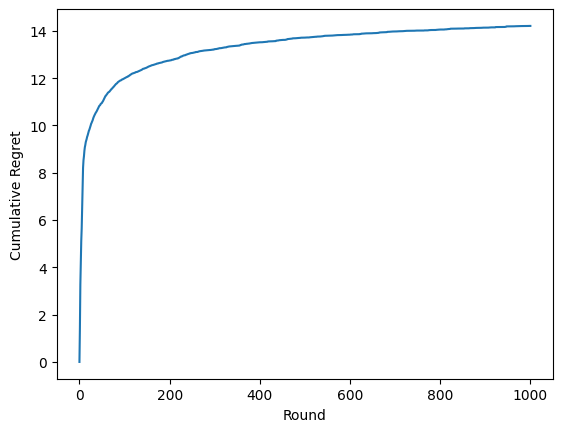

In [85]:
# Plotting the cumulative regret
plot_regret(regrets)

### 50 items

In [86]:
# Setting up parameters for the runs
n_arms = 50
n_features = 10
item_features = np.random.uniform(low=-1, high=1, size=(n_features, n_arms))
true_theta = np.random.uniform(low=-1, high=1, size=(n_features, 1))

n_rounds = 1000
noise = 0.1  # 0.1 -> can lead to negative regret since the reward could be the optimal + some noise
lambda_param = 0.5

n_simulations = 100

In [87]:
# Running the algorithm
regrets = run_lin_ucb_average(n_simulations, n_arms, n_features, item_features, n_rounds, true_theta, noise, lambda_param)

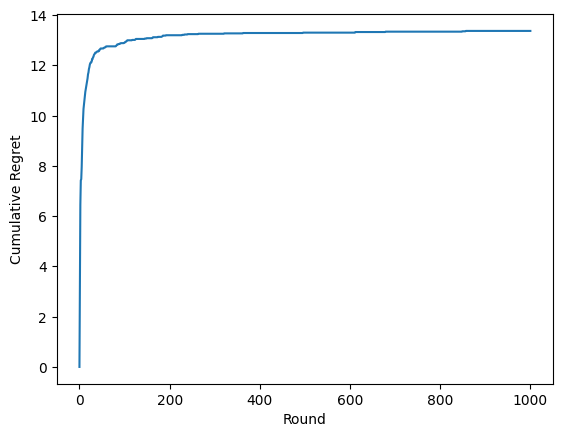

In [88]:
# Plotting the cumulative regret
plot_regret(regrets)

### 100 items

In [89]:
# Setting up parameters for the runs
n_arms = 100
n_features = 10
item_features = np.random.uniform(low=-1, high=1, size=(n_features, n_arms))
true_theta = np.random.uniform(low=-1, high=1, size=(n_features, 1))

n_rounds = 1000
noise = 0.1  # 0.1 -> can lead to negative regret since the reward could be the optimal + some noise
lambda_param = 0.5

n_simulations = 100

In [90]:
# Running the algorithm
regrets = run_lin_ucb_average(n_simulations, n_arms, n_features, item_features, n_rounds, true_theta, noise, lambda_param)

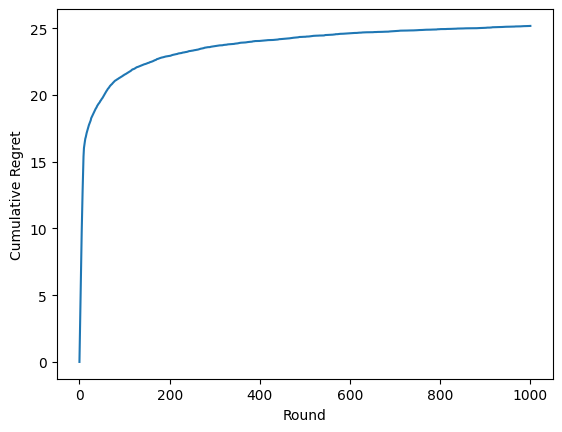

In [91]:
# Plotting the cumulative regret
plot_regret(regrets)

### Varying the number of arms

By keeping the number of features the same: 10 features, we see that as the number of arm increases, the cumulative regret converges faster (the logarithmic plot flattens out faster).

This leads to a cumulative regret being greater at step 1000 as we increase the number of arms.

This phenomenon can be explained by the fact that when there are more arms to chose, we can chose one arm that has is closest to the true feature vector theta. By increasing the number of arms, we increase the likelyhood of finding arms that fits the user the best. Therefore, it is logical that we converge to an estimate faster than with less arms.

## Varying the number of features

### 2 features

In [104]:
# Setting up parameters for the runs
n_arms = 100
n_features = 2
item_features = np.random.uniform(low=-1, high=1, size=(n_features, n_arms))
true_theta = np.random.uniform(low=-1, high=1, size=(n_features, 1))

n_rounds = 1000
noise = 0.1  # 0.1 -> can lead to negative regret since the reward could be the optimal + some noise
lambda_param = 0.5

n_simulations = 100

In [105]:
# Running the algorithm
regrets = run_lin_ucb_average(n_simulations, n_arms, n_features, item_features, n_rounds, true_theta, noise, lambda_param)

NameError: name 'run_lin_ucb_average' is not defined

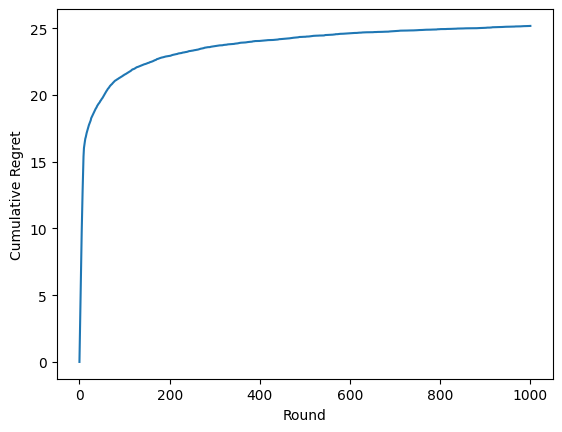

In [106]:
# Plotting the cumulative regret
plot_regret(regrets)

### 10 features

In [ ]:
# Setting up parameters for the runs
n_arms = 1000
n_features = 10
item_features = np.random.uniform(low=-1, high=1, size=(n_features, n_arms))
true_theta = np.random.uniform(low=-1, high=1, size=(n_features, 1))

n_rounds = 1000
noise = 0.1  # 0.1 -> can lead to negative regret since the reward could be the optimal + some noise
lambda_param = 0.5

n_simulations = 100

In [ ]:
# Running the algorithm
regrets = run_lin_ucb_average(n_simulations, n_arms, n_features, item_features, n_rounds, true_theta, noise, lambda_param)

In [ ]:
# Plotting the cumulative regret
plot_regret(regrets)

### 50 features

In [ ]:
# Setting up parameters for the runs
n_arms = 1000
n_features = 50
item_features = np.random.uniform(low=-1, high=1, size=(n_features, n_arms))
true_theta = np.random.uniform(low=-1, high=1, size=(n_features, 1))

n_rounds = 1000
noise = 0.1  # 0.1 -> can lead to negative regret since the reward could be the optimal + some noise
lambda_param = 0.5

n_simulations = 100

In [ ]:
# Running the algorithm
regrets = run_lin_ucb_average(n_simulations, n_arms, n_features, item_features, n_rounds, true_theta, noise, lambda_param)

In [ ]:
# Plotting the cumulative regret
plot_regret(regrets)

### 100 features

In [ ]:
# Setting up parameters for the runs
n_arms = 1000
n_features = 100
item_features = np.random.uniform(low=-1, high=1, size=(n_features, n_arms))
true_theta = np.random.uniform(low=-1, high=1, size=(n_features, 1))

n_rounds = 1000
noise = 0.1  # 0.1 -> can lead to negative regret since the reward could be the optimal + some noise
lambda_param = 0.5

n_simulations = 100

In [ ]:
# Running the algorithm
regrets = run_lin_ucb_average(n_simulations, n_arms, n_features, item_features, n_rounds, true_theta, noise, lambda_param)

In [ ]:
# Plotting the cumulative regret
plot_regret(regrets)

### 1000 features

In [94]:
# Setting up parameters for the runs
n_arms = 1000
n_features = 1000
item_features = np.random.uniform(low=-1, high=1, size=(n_features, n_arms))
true_theta = np.random.uniform(low=-1, high=1, size=(n_features, 1))

n_rounds = 1000
noise = 0.1  # 0.1 -> can lead to negative regret since the reward could be the optimal + some noise
lambda_param = 0.5

n_simulations = 100

In [95]:
# Running the algorithm
regrets = run_lin_ucb_average(n_simulations, n_arms, n_features, item_features, n_rounds, true_theta, noise, lambda_param)

KeyboardInterrupt: 

In [ ]:
# Plotting the cumulative regret
plot_regret(regrets)